In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage import io
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical

In [3]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [4]:
sm.set_framework('tf.keras')

## Loading the data

In [5]:
# jika data disimpan dalam numpy compressed
# (misalnya) np.savez_compressed('results/all_data_images_overlap_0.5.npz', all_images)
# maka diimport (load) demgan cara berikut:

all_images = np.load('results/all_data_images_overlap_0.5.npz')['arr_0']
all_masks = np.load('results/all_data_masks_overlap_0.5.npz')['arr_0']
all_labels = np.load('results/all_data_labels_overlap_0.5.npz')['arr_0']

In [6]:
print(all_images.shape)
print(all_masks.shape)
print(all_labels.shape)

(5839, 256, 256, 3)
(5839, 256, 256, 4)
(5839, 256, 256, 1)


### Ubah ke Categorical

In [7]:
all_cats = to_categorical(all_labels, num_classes=5)

In [8]:
all_cats.shape

(5839, 256, 256, 5)

Class yang ada dalam Cell:  [0. 1. 2.]


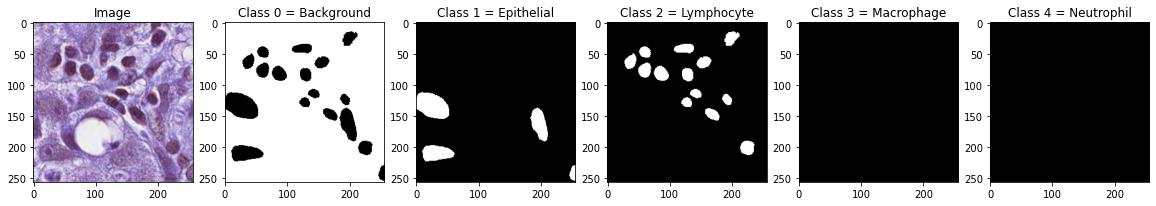

In [9]:
cek_ind=0
plt.figure(figsize=(20,4))
plt.subplot(1,6,1)
plt.imshow(all_images[cek_ind]);
plt.title('Image')
plt.subplot(1,6,2)
plt.imshow(all_cats[cek_ind][:,:,0], cmap='gray');
plt.title('Class 0 = Background')
plt.subplot(1,6,3)
plt.imshow(all_cats[cek_ind][:,:,1], cmap='gray');
plt.title('Class 1 = Epithelial')
plt.subplot(1,6,4)
plt.imshow(all_cats[cek_ind][:,:,2], cmap='gray');
plt.title('Class 2 = Lymphocyte')
plt.subplot(1,6,5)
plt.imshow(all_cats[cek_ind][:,:,3], cmap='gray');
plt.title('Class 3 = Macrophage')
plt.subplot(1,6,6)
plt.imshow(all_cats[cek_ind][:,:,4], cmap='gray');
plt.title('Class 4 = Neutrophil')

print("Class yang ada dalam Cell: ", np.unique(all_labels[cek_ind]))

### Prepare Training, Validation Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_cats, test_size=0.2, random_state=0)

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [12]:
print("Data latih: ", X_train.shape)
print("Data validasi: ", X_val.shape)
print("Data uji: ", X_test.shape)

print("Label data latih:", y_train.shape)
print("Label data validasi:", y_val.shape)
print("Label data uji:", y_test.shape)

Data latih:  (4671, 256, 256, 3)
Data validasi:  (584, 256, 256, 3)
Data uji:  (584, 256, 256, 3)
Label data latih: (4671, 256, 256, 5)
Label data validasi: (584, 256, 256, 5)
Label data uji: (584, 256, 256, 5)


## Model CNN
### Encoder - EfficientNet B3

In [13]:
n_classes=5
activation='softmax'

In [14]:
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
X_train_input = preprocess_input(X_train)
X_val_input = preprocess_input(X_val)

In [16]:
# define model
# Downloading data from https://github.com/Callidior/keras-applications/releases/download/efficientnet/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5
model = sm.Unet(BACKBONE,encoder_weights='imagenet', classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 12s 0us/step


### Train the Model

In [23]:
epochs = 20
batch_size = 2
lr = 1e-4
x_axis_inc = 1

In [18]:
def plot_history(sejarah, fig_train, epochs, subtitle, acc_ylim = 1, loss_ylim=1.2, figsize=(14, 4), x_axis_inc=1):
    epoch_list = list(range(1,epochs+1))
    y_train_acc = sejarah.history['accuracy'] # binary_accuracy  accuracy
    y_val_acc = sejarah.history['val_accuracy'] # val_binary_accuracy  val_accuracy
    y_train_loss = sejarah.history['loss']
    y_val_loss = sejarah.history['val_loss']
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    t = f.suptitle(subtitle, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    ax1.plot(epoch_list, y_train_acc, label='Train Accuracy')
    ax1.plot(epoch_list, y_val_acc, label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax1.set_ylim(0.2,acc_ylim)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, y_train_loss, label='Train Loss')
    ax2.plot(epoch_list, y_val_loss, label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax2.set_ylim(0,loss_ylim)
    ax2.set_ylabel('Cross Entropy')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    plt.savefig(fig_train)

In [19]:
fig_train = 'D:/dataset/MoNuSAC/results/monusac_efficientnetb3_unet_ov5_home'
log_file = 'D:/dataset/MoNuSAC/results/monusac_efficientnetb3_unet_ov5_home.csv'
model_path = 'D:/dataset/MoNuSAC/results/monusac_efficientnetb3_unet_ov5_home.h5'
sub_title = 'Multi-organ Nuclei Segmentation using EfficientNet B3 - UNet'

In [24]:
# Jangan lupa meng-compile setiap kali mengubah struktur atau parameter model
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=lr),
              metrics=["accuracy"])

In [25]:
callbacks = [CSVLogger(log_file),  ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)]

In [26]:
history = model.fit(X_train_input, y_train, validation_data=(X_val_input, y_val), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/20
2336/2336 [==============================] - 204s 83ms/step - loss: 0.4016 - accuracy: 0.8793 - val_loss: 0.2016 - val_accuracy: 0.9295


C:\ProgramData\Anaconda3\envs\ta\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
2336/2336 [==============================] - 182s 78ms/step - loss: 0.2195 - accuracy: 0.9246 - val_loss: 0.1862 - val_accuracy: 0.9280
Epoch 3/20
2336/2336 [==============================] - 181s 77ms/step - loss: 0.1698 - accuracy: 0.9389 - val_loss: 0.1606 - val_accuracy: 0.9403
Epoch 4/20
2336/2336 [==============================] - 184s 79ms/step - loss: 0.1449 - accuracy: 0.9464 - val_loss: 0.1633 - val_accuracy: 0.9374
Epoch 5/20
2336/2336 [==============================] - 188s 80ms/step - loss: 0.1222 - accuracy: 0.9536 - val_loss: 0.1323 - val_accuracy: 0.9500
Epoch 6/20
2336/2336 [==============================] - 190s 81ms/step - loss: 0.1093 - accuracy: 0.9580 - val_loss: 0.1210 - val_accuracy: 0.9544
Epoch 7/20
2336/2336 [==============================] - 183s 78ms/step - loss: 0.0998 - accuracy: 0.9610 - val_loss: 0.1924 - val_accuracy: 0.9313
Epoch 8/20
2336/2336 [==============================] - 189s 81ms/step - loss: 0.0897 - accuracy: 0.9643 - val_loss: 0

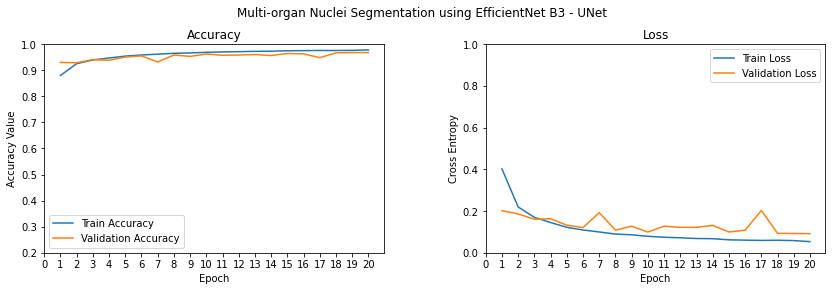

In [28]:
plot_history(history, fig_train, epochs, sub_title, loss_ylim=1)

### Inference Process

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
# Use this code if you just run the notebook for the inferences process
# If you train the model from the beginning, you can do the inferences directly without running this line code
new_model = tf.keras.models.load_model(model_path)

In [29]:
X_test_new = preprocess_input(X_test)

In [31]:
# Lakukan prediksi untuk testing data
y_test_predict = model.predict(X_test_new, batch_size = batch_size)

ResourceExhaustedError: OOM when allocating tensor with shape[584,256,256,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [51]:
X_test_new1 = X_test_new[:20]
X_test_new1.shape

(20, 256, 256, 3)

In [52]:
y_test_predict1 = model.predict(X_test_new1)

In [64]:
step = 20
repeat = int(X_test_new.shape[0] / step)
repeat

29

In [70]:
pred_concat = y_test_predict1
pred_concat.shape

(20, 256, 256, 5)

In [71]:
for i in range(repeat):
    indx = step*(i+1)
    pred = model.predict(X_test_new[indx:indx+step])
    pred_concat = np.concatenate((pred_concat, pred))

In [72]:
pred_concat.shape

(584, 256, 256, 5)

In [73]:
y_test_predict = pred_concat

Testing index = 583


Text(0.5, 1.0, 'Class 4 - Neutrophil')

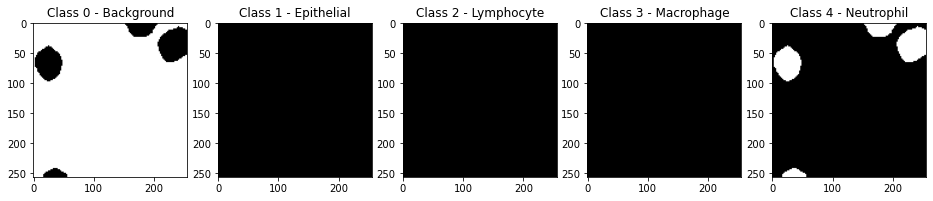

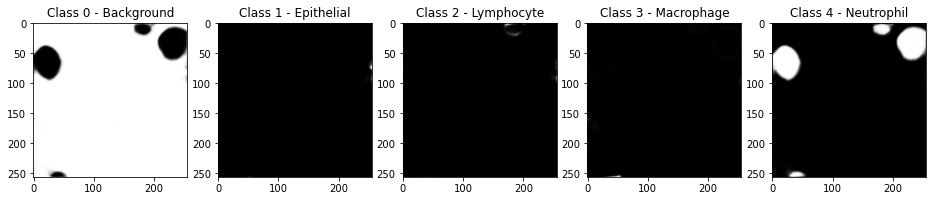

In [81]:
#ind_test = random.randint(0, X_test.shape[0]-1)
ind_test = 583 # 3 51 524 486
print("Testing index =", ind_test)

# Ground Truth
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.imshow(y_test[ind_test][:,:,0], cmap='gray');
plt.title('Class 0 - Background')

plt.subplot(1,5,2)
plt.imshow(y_test[ind_test][:,:,1], cmap='gray');
plt.title('Class 1 - Epithelial')

plt.subplot(1,5,3)
plt.imshow(y_test[ind_test][:,:,2], cmap='gray');
plt.title('Class 2 - Lymphocyte')

plt.subplot(1,5,4)
plt.imshow(y_test[ind_test][:,:,3], cmap='gray');
plt.title('Class 3 - Macrophage')

plt.subplot(1,5,5)
plt.imshow(y_test[ind_test][:,:,4], cmap='gray');
plt.title('Class 4 - Neutrophil')

# Prediction
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.imshow(y_test_predict[ind_test][:,:,0], cmap='gray');
plt.title('Class 0 - Background')

plt.subplot(1,5,2)
plt.imshow(y_test_predict[ind_test][:,:,1], cmap='gray');
plt.title('Class 1 - Epithelial')

plt.subplot(1,5,3)
plt.imshow(y_test_predict[ind_test][:,:,2], cmap='gray');
plt.title('Class 2 - Lymphocyte')

plt.subplot(1,5,4)
plt.imshow(y_test_predict[ind_test][:,:,3], cmap='gray');
plt.title('Class 3 - Macrophage')

plt.subplot(1,5,5)
plt.imshow(y_test_predict[ind_test][:,:,4], cmap='gray');
plt.title('Class 4 - Neutrophil')

In [82]:
np.savez_compressed('D:/dataset/MoNuSAC/results/monusac_efficientnetb3_unet_predict_test_ov5_home.npz', y_test_predict)